In [2]:
import numpy as np
import matplotlib.pyplot as plt

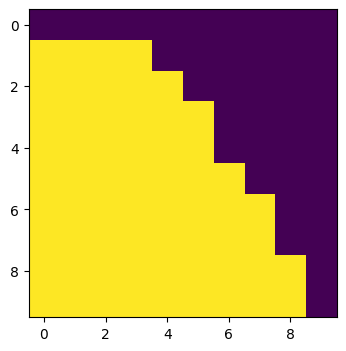

In [3]:
num_points = 10
x = np.linspace(0, 1, num_points)
y = np.linspace(0, 1, num_points)
def bool_domain_gen(x, y, num_points):
    x_g, y_g = np.meshgrid(x, np.sqrt(1-y))
    y_g = y_g[::-1]
    bool_domain = x_g < y_g
    return bool_domain

bool_domain = bool_domain_gen(x, y, num_points)


plt.figure(figsize = (4,4))
plt.imshow(bool_domain)

In [4]:
from math import floor

def domain(M):
    h = 1/M

    x = np.linspace(0,1,M)
    y = np.linspace(0,1,M)
    #P = (np.sqrt(1-y)//h).astype(int)
    P = (np.sqrt(1-y)//h).astype(int)
    return P

print(domain(10))

[9 9 8 8 7 6 5 4 3 0]


In [5]:
def normal_dirichlet(boundaries, alpha = 1, beta = 1):
    """ Create a one-dimensional vector for Dirichlet conditions. Uses natural ordering.

    Args:
        G (array(4 x M-1)): Matrix with row vectors corresponding respectively to boundary at x = x0, y = y0, x = xend, y = yend
        alpha, beta (floats): Constants as defined in text. Optional arguments. 

    Returns:
        g (array(M-1)^2): One dimensional array meant for use in linear system, using natural ordering
    """
    l, t, r, b = boundaries
    M = l.shape[0] - 1         # l is M+1
    G = np.zeros((M-1, M-1))
    G[0, 1:] += beta * b[2:M]
    G[-1, :-1] += beta * t[2: M]
    G[:, 0] += alpha * l[1:M]
    G[:, -1] += alpha * r[1:M]
    """plt.imshow(G)
    plt.show()"""
    return G.flatten()


# Testing
M = 5
l = np.arange(M+1)
t = np.zeros(M+1)
r = np.zeros(M+1)
b = np.arange(M+1)

g2 = normal_dirichlet([l, t, r, b], 1, 1)
#G = np.flip(g2.reshape((M-1,M-1)), 0)
print(np.flip(g2.reshape((M-1,M-1)), 0))
#np.pad(G, [(1,1)])

[[4. 0. 0. 0.]
 [3. 0. 0. 0.]
 [2. 0. 0. 0.]
 [1. 2. 3. 4.]]


16.0
ah:3


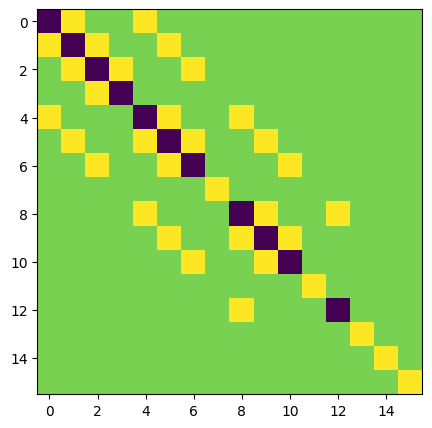

In [6]:
def ndiag(consts, offsets, N):
    """Generate a matrix with arbitrary number of constant diagonals, 0 elsewhere

    Args:
        consts (list of floats):    list containing floats on diagonal
        offsets (list of ints):     list of offsets. Corresponds to the consts list
        N (int):                    length of array

    Returns:
        A (N x N matrix):           matrix with diagonals as specified
    """
    diags = []
    for i in range(len(consts)):
        diags.append(consts[i] * np.ones(N - np.abs(offsets[i])))

    A = np.zeros((N,N))
    for i in range(len(diags)):
        A += np.diag(diags[i], offsets[i])
    return A

def triblock_mod(C, B, M, domain_vec):
    A = np.kron(np.eye(M-1), C)
    A += np.kron(ndiag([1,1], [-1, 1], M-1), B)
    if np.size(A) != len(domain_vec)**4:
        print("np.size(A) != len(domain_vec)**4")
        print(np.size(A))
        print(len(domain_vec)**4)
    for i in range(len(domain_vec)):
        A[(i*(len(domain_vec))+domain_vec[i]):(i+1)*(len(domain_vec)), :] = 0
    print(np.sqrt(np.size(A)))
    for i in range(len(domain_vec)**2):
        if A[i,i] == 0:
            A[i,i] = 1
    for i in range(len(domain_vec)**2):
        if A[i,i] != 1:
            if A[i+1,i+1] == 1:
                A[i,i+1] = 0
            if i < len(domain_vec)**2 - len(domain_vec):
                if A[i+len(domain_vec),i+len(domain_vec)] == 1:
                    A[i, i+len(domain_vec)] = 0
        
    return A

# Testing
M = 5
C = ndiag([1,-4,1], [-1,0,1], (M-1))
B = 1 * np.eye(M-1)


A = triblock_mod(C, B, M, [4,3,3,1])



print("ah:"+str(len([3,2,1])))
plt.figure(0, figsize = (5,5))
plt.imshow(A)
plt.show()

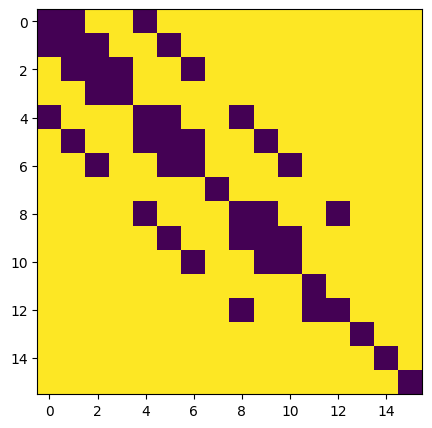

In [7]:
def equation_fixer(A, g2, domain_vec, M, b_functioin):
    h = 1/M
    if np.size(A) != len(domain_vec)**4:
        print("np.size(A) != len(domain_vec)**4")
    if np.size(A) != len(g2)**2:
        print("np.size(A) != len(g2)**2")
    for i in range(len(domain_vec)**2):
        if A[i,i] != 1:
            if A[i,i+1] == 0 or A[i, i+len(domain_vec)] == 0:
                x_p = (i%len(domain_vec)+1)*h
                y_p = (i//len(domain_vec)+1)*h
                eta = 1 - x_p**2 - y_p
                xsi = np.sqrt(1-y_p) - x_p
                
                A[i,i] = -(-2/(xsi*h**2) - 2/(eta*h**2))
                A[i,i-1] =  2 / ((1+xsi)*(h**2))
                A[i, i+1] *= ( 2 / (xsi*(1+xsi)*(h**2)) )
                if i > len(domain_vec):
                    A[i, i-len(domain_vec)] =  2 / ((h**2)*(1+eta))
                if i < len(domain_vec)**2 - len(domain_vec):
                    A[i, i+len(domain_vec)] *=  ( 2 / (eta*(h**2)*(1+eta)) )
                """
                A[i,i] = 5
                
                A[i,i-1] = 5
                A[i, i+1] = A[i, i+1]*5
                if i > len(domain_vec):
                    A[i, i-len(domain_vec)] = 5
                if i < len(domain_vec)**2 - len(domain_vec):
                    A[i, i+len(domain_vec)] = A[i, i+len(domain_vec)]*5
                """
                if A[i+1,i+1] == 1:
                    g2[i] += ( 2 / (xsi*(1+xsi)*(h**2)) ) * b_functioin(x_p + xsi, y_p)
                if i < len(domain_vec)**2 - len(domain_vec):
                    if A[i+len(domain_vec),i+len(domain_vec)] == 1:
                        g2[i] += ( 2 / (eta*(h**2)*(1+eta)) ) * b_functioin(x_p, y_p + eta)
                        
                
    return A, g2




left = np.arange(M+1)
top = np.zeros(M+1)
right = np.zeros(M+1)
bottom = np.arange(M+1)


g2 = normal_dirichlet([left, top, right, bottom], 1, 1)

def bndry_func(x,y):
    return x+y

A, g2 = equation_fixer(A, g2, [4,3,3,1], M, bndry_func)
plt.figure(0, figsize = (5,5))
for i in range(int(np.sqrt(np.size(A)))):
    for j in range(int(np.sqrt(np.size(A)))):
        if A[i,j] == 0:
            A[i,j] = True
        else:
            A[i,j] = False
plt.imshow(A)
plt.show()

In [8]:
for i in range(int(np.sqrt(np.size(A)))):
    for j in range(int(np.sqrt(np.size(A)))):
        if A[i,j] == 0:
            A[i,j] = True
        else:
            A[i,j] = False

In [9]:
def f_fixer(function_vec, domain_vec):
    mod_f_vec = function_vec
    for i in range(len(function_vec)):
        if function_vec[i] > domain_vec[i//len(domain_vec)]:
            mod_f_vec[i] = 0
    return mod_f_vec

2401.0


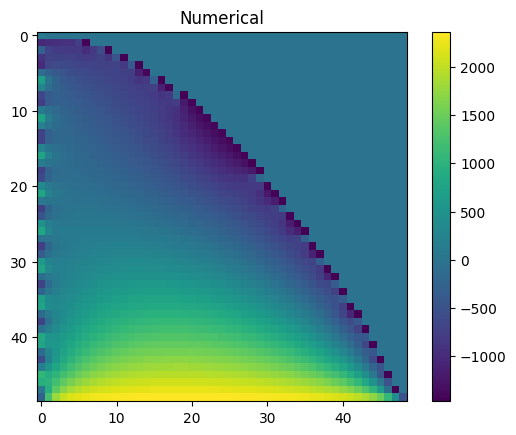

In [13]:
M = 50
h = 1/M
a = 1

left = np.arange(M+1)
left = np.sin(left*5)
top = np.zeros(M+1)
right = np.zeros(M+1)
bottom = np.ones(M+1)
g2 = normal_dirichlet([left, top, right, bottom], a/h**2, 1/h**2)

def bndry_func(x,y):
    return 1500

C = ndiag([1,-4,1], [-1,0,1], (M-1))
B = 1 * np.eye(M-1)

omega = domain(M-1)

funtion = f_fixer(np.ones((M-1)**2), omega)

A = triblock_mod(C, B, M, omega)

A, g2 = equation_fixer(A, g2, omega, M, bndry_func)

U_vec = np.linalg.solve(A, -g2 - funtion)
U = U_vec.reshape((M-1, M-1))[::-1]

plt.title('Numerical')
plt.imshow(U)
plt.colorbar()
plt.show()